## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Which disease are associate with NPM1 gene?
#### Example 2: Which proteins interacts with protein NPM1?
#### Example 3: Which drugs or small molecules can interact with NPM1?


In [5]:
import sys
sys.path.append('../TCT')
sys.path.append('../TCT/translator_metakg')
sys.path.append('../TCT/translator_kpinfo')
sys.path.append('../TCT/name_resolver')
sys.path.append('../TCT/node_normalizer')
sys.path.append('../TCT/TCT')

import TCT as TCT
import translator_metakg
import translator_kpinfo


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import pandas as pd
import  seaborn as sns
import networkx as nx
import numpy as np
import ipycytoscape
import yaml

In [6]:
# Preparation 
# Step1: List all the APIs in the translator system
Translator_KP_info,APInames= translator_kpinfo.get_translator_kp_info()
print(len(Translator_KP_info))
# Step 2: Get metaKG and all predicates from Translator APIs through the SmartAPI system
metaKG = translator_metakg.get_KP_metadata(APInames) 
print(metaKG.shape)
# Add metaKG from Plover API based KG resources
APInames,metaKG = translator_metakg.add_plover_API(APInames, metaKG)
print(metaKG.shape)
# Step 3: list metaKG information
All_predicates = list(set(metaKG['Predicate']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))
API_withMetaKG = list(set(metaKG['API']))
print(len(API_withMetaKG))
print(len(All_predicates))
print(len(All_categories))

# ARA list
API_withMetaKG = set(metaKG['API'])
print("ARA list:", set(APInames.keys()) - API_withMetaKG)
# find the KG in one individual API (optional)
#metaKG.loc[metaKG['API'] == 'CATRAX Pharmacogenomics KP - TRAPI 1.5.0',['API','Predicate','Subject','Object']].drop_duplicates()

53
(10580, 5)
(22129, 5)
42
184
108
ARA list: {'Workflow-runner(Trapi v1.5.0)', 'Sri-answer-appraiser(Trapi v1.5.0)', 'mediKanren', 'OpenPredict API', 'Autonomous Relay System (ARS) TRAPI', 'Sri-node-normalizer(Trapi v1.5.0)', 'Aragorn(Trapi v1.5.0)', 'Cqs(Trapi v1.5.0)', 'Answer-coalesce(Trapi v1.5.0)', 'ARAX Translator Reasoner - TRAPI 1.5.0'}


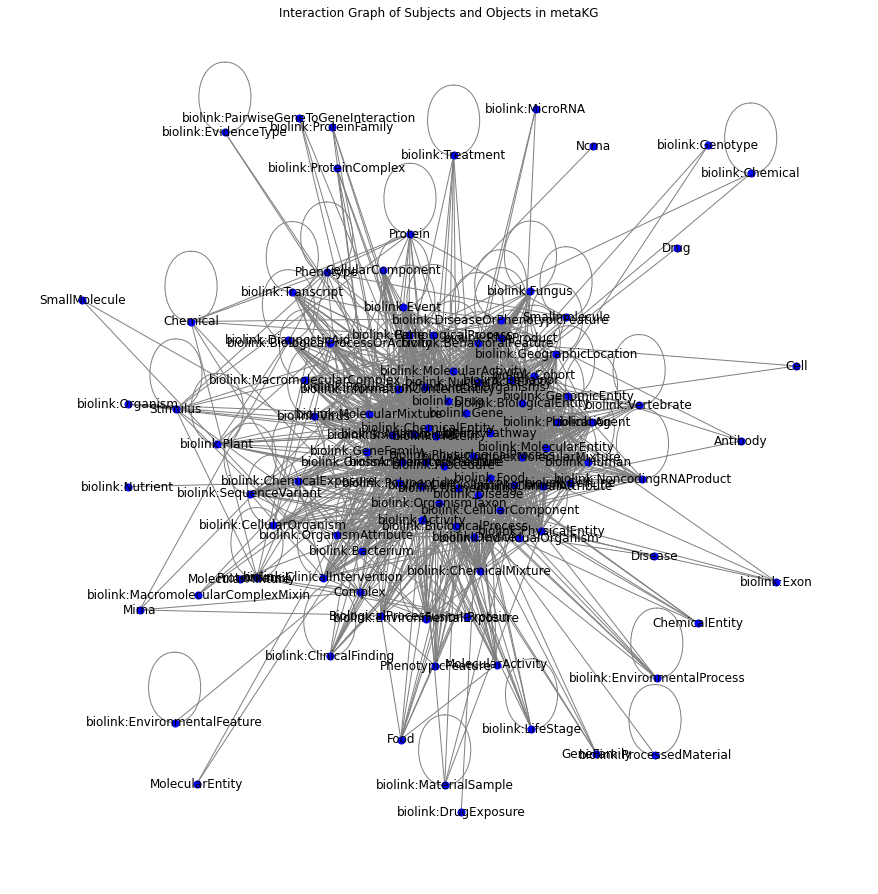

In [7]:
# draw the interaction graph between subject and object in the metaKG using networkx
# first, we need to drop the interactions between subjects and objects that both subjects and objects are the same
#metaKG = metaKG[metaKG['Subject'] != metaKG['Object']]
# second, we need to filter the metaKG to only include the selected categories
#metaKG = metaKG[metaKG['Subject'].isin(selected_categories) | metaKG['Object'].isin(selected_categories)]
G = nx.from_pandas_edgelist(metaKG, source='Subject', target='Object', edge_attr='Predicate')
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=20)
nx.draw(G, pos, with_labels=True, 
        node_size=50, font_size=12, 
        font_color='black', 
        node_color='blue', 
        edge_color='gray')
plt.title('Interaction Graph of Subjects and Objects in metaKG')
plt.show()

In [12]:
# Find everything that is connected to a specific node

In [8]:
input_node1 = 'FLT3'

# We need to get the id and the category of the input node 


In [6]:
# Step 3: set input parameters
# Test multiomics BigGIM Drug Response KP
# Node1 for query
input_node1 = 'FLT3'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']
#input_node2_category = ['biolink:Gene']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))



print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

NCBIGene:2322
all relevant predicates in Translator:
['biolink:affects_response_to', 'biolink:response_affected_by', 'biolink:is_substrate_of', 'biolink:similar_to', 'biolink:produces', 'biolink:disrupts', 'biolink:part_of', 'biolink:derives_into', 'biolink:output_of', 'biolink:occurs_together_in_literature_with', 'biolink:derives_from', 'biolink:correlated_with', 'biolink:increases_response_to', 'biolink:sensitivity_associated_with', 'biolink:associated_with_decreased_likelihood_of', 'biolink:positively_correlated_with', 'biolink:related_to_at_instance_level', 'biolink:coexists_with', 'biolink:has_gene_product', 'biolink:has_substrate', 'biolink:produced_by', 'biolink:affects', 'biolink:disrupted_by', 'biolink:physically_interacts_with', 'biolink:gene_product_of', 'biolink:decreases_response_to', 'biolink:has_part', 'biolink:regulates', 'biolink:associated_with_increased_likelihood_of', 'biolink:directly_physically_interacts_with', 'biolink:affected_by', 'biolink:resistance_associated

In [7]:
# can use large language model to select predicates
sele_predicates = ['biolink:associated_with_resistance_to',
                   'biolink:associated_with_sensitivity_to', 
                   'biolink:occurs_together_in_literature_with',
                   'biolink:physically_interacts_with']

In [8]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates
query_json

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:2322'],
     'categories': ['biolink:Gene']},
    'n1': {'categories': ['biolink:Drug',
      'biolink:SmallMolecule',
      'biolink:ChemicalSubstance']}},
   'edges': {'e1': {'subject': 'n0',
     'object': 'n1',
     'predicates': ['biolink:associated_with_resistance_to',
      'biolink:associated_with_sensitivity_to',
      'biolink:occurs_together_in_literature_with',
      'biolink:physically_interacts_with']}}}}}

In [9]:

# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


Warning Code:404:https://molepro-trapi.transltr.io/molepro/trapi/v1.5/query/
Warning Code:422:https://automat.transltr.io/hmdb/query/
Warning Code:422:https://automat.transltr.io/ctd/query/
Success!https://automat.transltr.io/cam-kp/query/
Success!https://automat.transltr.io/hetio/query/
Warning Code:422:https://automat.transltr.io/icees-kg/query/
Success!https://automat.transltr.io/gtopdb/query/
Warning Code:422:https://automat.renci.org/ehr-may-treat-kp/query/
Warning Code:422:https://automat.renci.org/ehr-clinical-connections-kp/query/
Success!https://automat.transltr.io/pharos/query/
Success!https://automat.transltr.io/robokopkg/query/
Success!https://bte.transltr.io/v1/team/Service%20Provider/query/
Success!https://bte.transltr.io/v1/query/
CHEMBL.COMPOUND:CHEMBL4795462: no preferred name
CHEMBL.COMPOUND:CHEMBL4798601: no preferred name
CHEMBL.COMPOUND:CHEMBL3656365: no preferred name
CHEMBL.COMPOUND:CHEMBL3656366: no preferred name
CHEMBL.COMPOUND:CHEMBL3656369: no preferred name

In [14]:
result_ranked_by_primary_infores

,output_node,Name,Num_of_primary_infores,type_of_nodes,unique_predicates
423,CHEBI:63452,Midostaurin,5,object,"[biolink:physically_interacts_with, biolink:ph..."
421,CHEBI:78543,Ponatinib,5,object,"[biolink:physically_interacts_with, biolink:ph..."
439,CHEBI:91408,Fedratinib,4,object,"[biolink:physically_interacts_with, biolink:oc..."
422,CHEBI:91471,LSM-1231,4,object,"[biolink:physically_interacts_with, biolink:oc..."
448,CHEBI:49960,Vandetanib,4,object,"[biolink:physically_interacts_with, biolink:oc..."
...,...,...,...,...,...
1651,PUBCHEM.COMPOUND:118439773,4-[[2-(butylamino)-5-[5-[[(3R)-3-(dimethylamin...,1,object,"[biolink:physically_interacts_with, biolink:ph..."
1652,INCHIKEY:QQTWEWAFAIDGJB-MXVIHJGJSA-N,INCHIKEY:QQTWEWAFAIDGJB-MXVIHJGJSA-N,1,object,"[biolink:physically_interacts_with, biolink:ph..."
1653,PUBCHEM.COMPOUND:117849653,2-[[2-(Butylamino)-5-pyridin-2-ylpyrimidin-4-y...,1,object,"[biolink:physically_interacts_with, biolink:ph..."
1654,INCHIKEY:WORRXRIVSMTSEB-CXIWYSOXSA-N,INCHIKEY:WORRXRIVSMTSEB-CXIWYSOXSA-N,1,object,"[biolink:physically_interacts_with, biolink:ph..."


In [15]:
print(query_json)

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:2322'], 'categories': ['biolink:Gene']}, 'n1': {'categories': ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:associated_with_resistance_to', 'biolink:associated_with_sensitivity_to', 'biolink:occurs_together_in_literature_with', 'biolink:physically_interacts_with']}}}}}


CHEMBL.COMPOUND:CHEMBL4795462: no preferred name
CHEMBL.COMPOUND:CHEMBL4798601: no preferred name
CHEMBL.COMPOUND:CHEMBL4851303: no preferred name
CHEMBL.COMPOUND:CHEMBL4216043: no preferred name
CHEMBL.COMPOUND:CHEMBL4203825: no preferred name
CHEMBL.COMPOUND:CHEMBL4764646: no preferred name
CHEMBL.COMPOUND:CHEMBL45177: no preferred name
CHEMBL.COMPOUND:CHEMBL4861169: no preferred name
CHEMBL.COMPOUND:CHEMBL4849169: no preferred name
CHEMBL.COMPOUND:CHEMBL4277445: no preferred name
CHEMBL.COMPOUND:CHEMBL4282510: no preferred name
CHEMBL.COMPOUND:CHEMBL4279673: no preferred name
CHEMBL.COMPOUND:CHEMBL4284541: no preferred name
CHEMBL.COMPOUND:CHEMBL4212241: no preferred name
CHEMBL.COMPOUND:CHEMBL4208669: no preferred name
CHEMBL.COMPOUND:CHEMBL3237706: no preferred name
CHEMBL.COMPOUND:CHEMBL3237707: no preferred name
CHEMBL.COMPOUND:CHEMBL3237708: no preferred name
CHEMBL.COMPOUND:CHEMBL3237709: no preferred name
CHEMBL.COMPOUND:CHEMBL3237710: no preferred name
CHEMBL.COMPOUND:CHEMBL

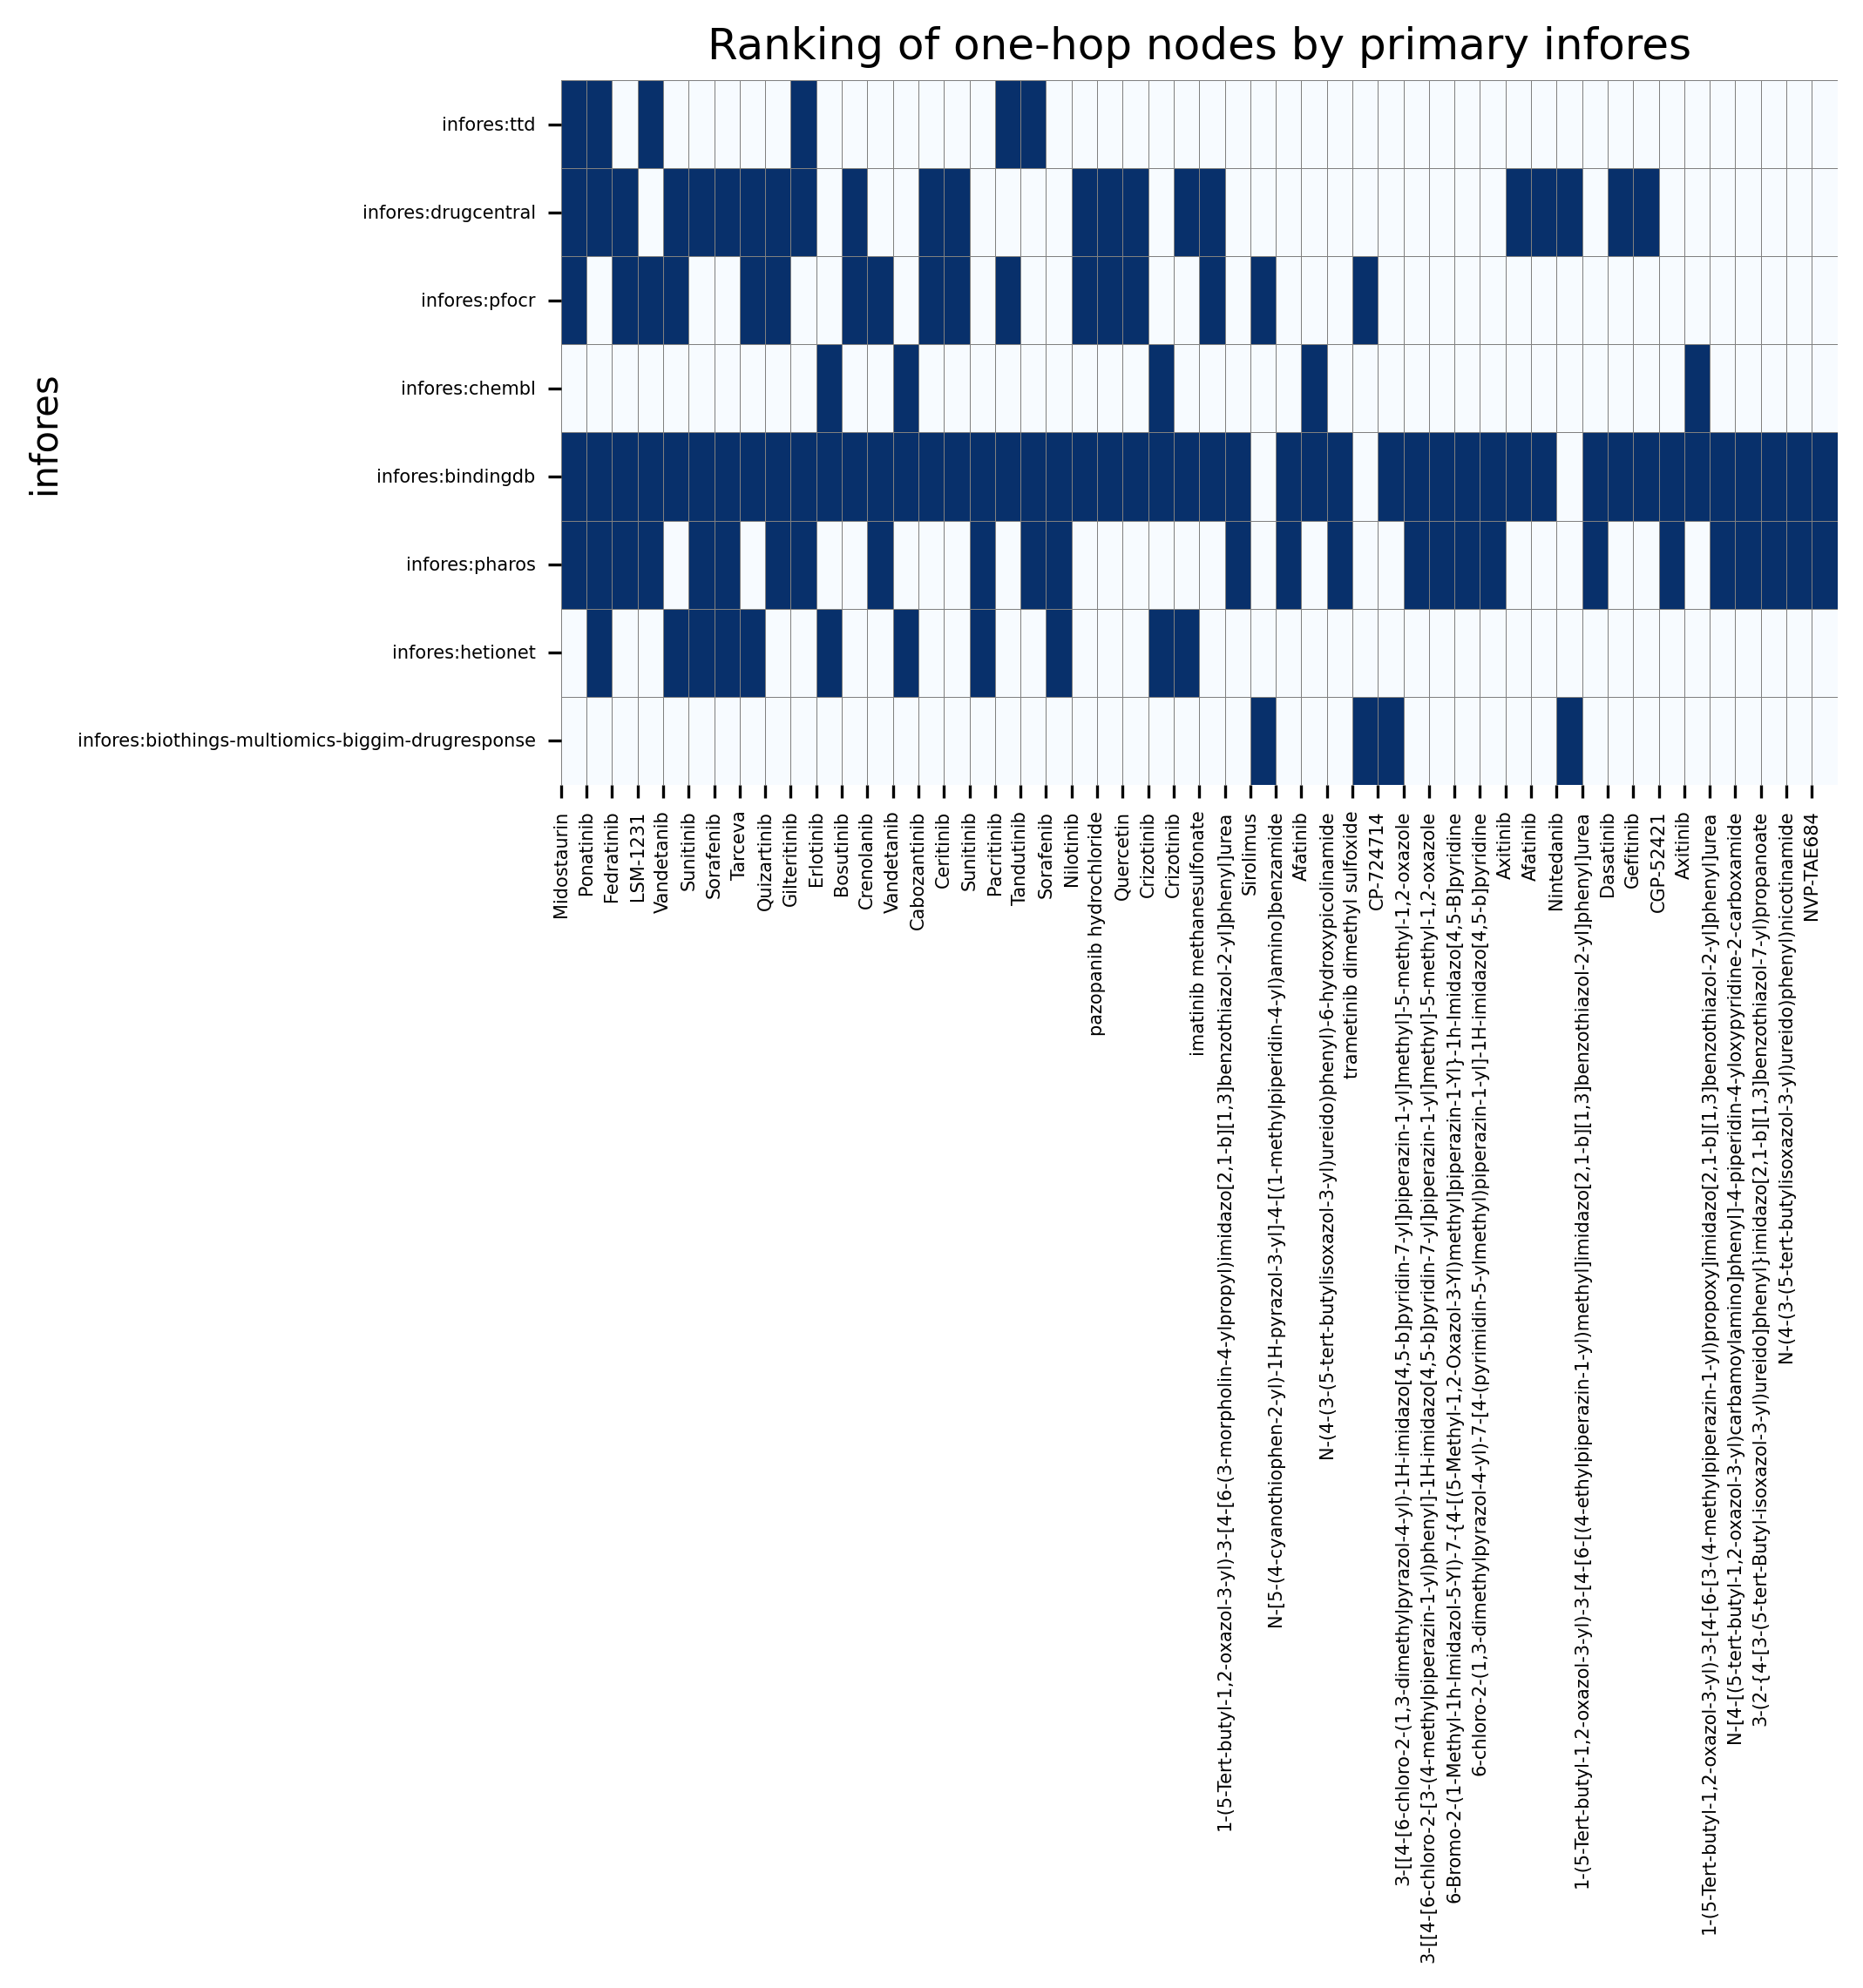

[Text(0.5, 0, 'Midostaurin'), Text(2.5, 0, 'Fedratinib'), Text(4.5, 0, 'Vandetanib'), Text(6.5, 0, 'Sorafenib'), Text(8.5, 0, 'Quizartinib'), Text(10.5, 0, 'Erlotinib'), Text(12.5, 0, 'Crenolanib'), Text(14.5, 0, 'Cabozantinib'), Text(16.5, 0, 'Sunitinib'), Text(18.5, 0, 'Tandutinib'), Text(20.5, 0, 'Nilotinib'), Text(22.5, 0, 'Quercetin'), Text(24.5, 0, 'Crizotinib'), Text(26.5, 0, '1-(5-Tert-butyl-1,2-oxazol-3-yl)-3-[4-[6-(3-morpholin-4-ylpropyl)imidazo[2,1-b][1,3]benzothiazol-2-yl]phenyl]urea'), Text(28.5, 0, 'N-[5-(4-cyanothiophen-2-yl)-1H-pyrazol-3-yl]-4-[(1-methylpiperidin-4-yl)amino]benzamide'), Text(30.5, 0, 'N-(4-(3-(5-tert-butylisoxazol-3-yl)ureido)phenyl)-6-hydroxypicolinamide'), Text(32.5, 0, 'CP-724714'), Text(34.5, 0, '3-[[4-[6-chloro-2-[3-(4-methylpiperazin-1-yl)phenyl]-1H-imidazo[4,5-b]pyridin-7-yl]piperazin-1-yl]methyl]-5-methyl-1,2-oxazole'), Text(36.5, 0, '6-chloro-2-(1,3-dimethylpyrazol-4-yl)-7-[4-(pyrimidin-5-ylmethyl)piperazin-1-yl]-1H-imidazo[4,5-b]pyridine'), Te

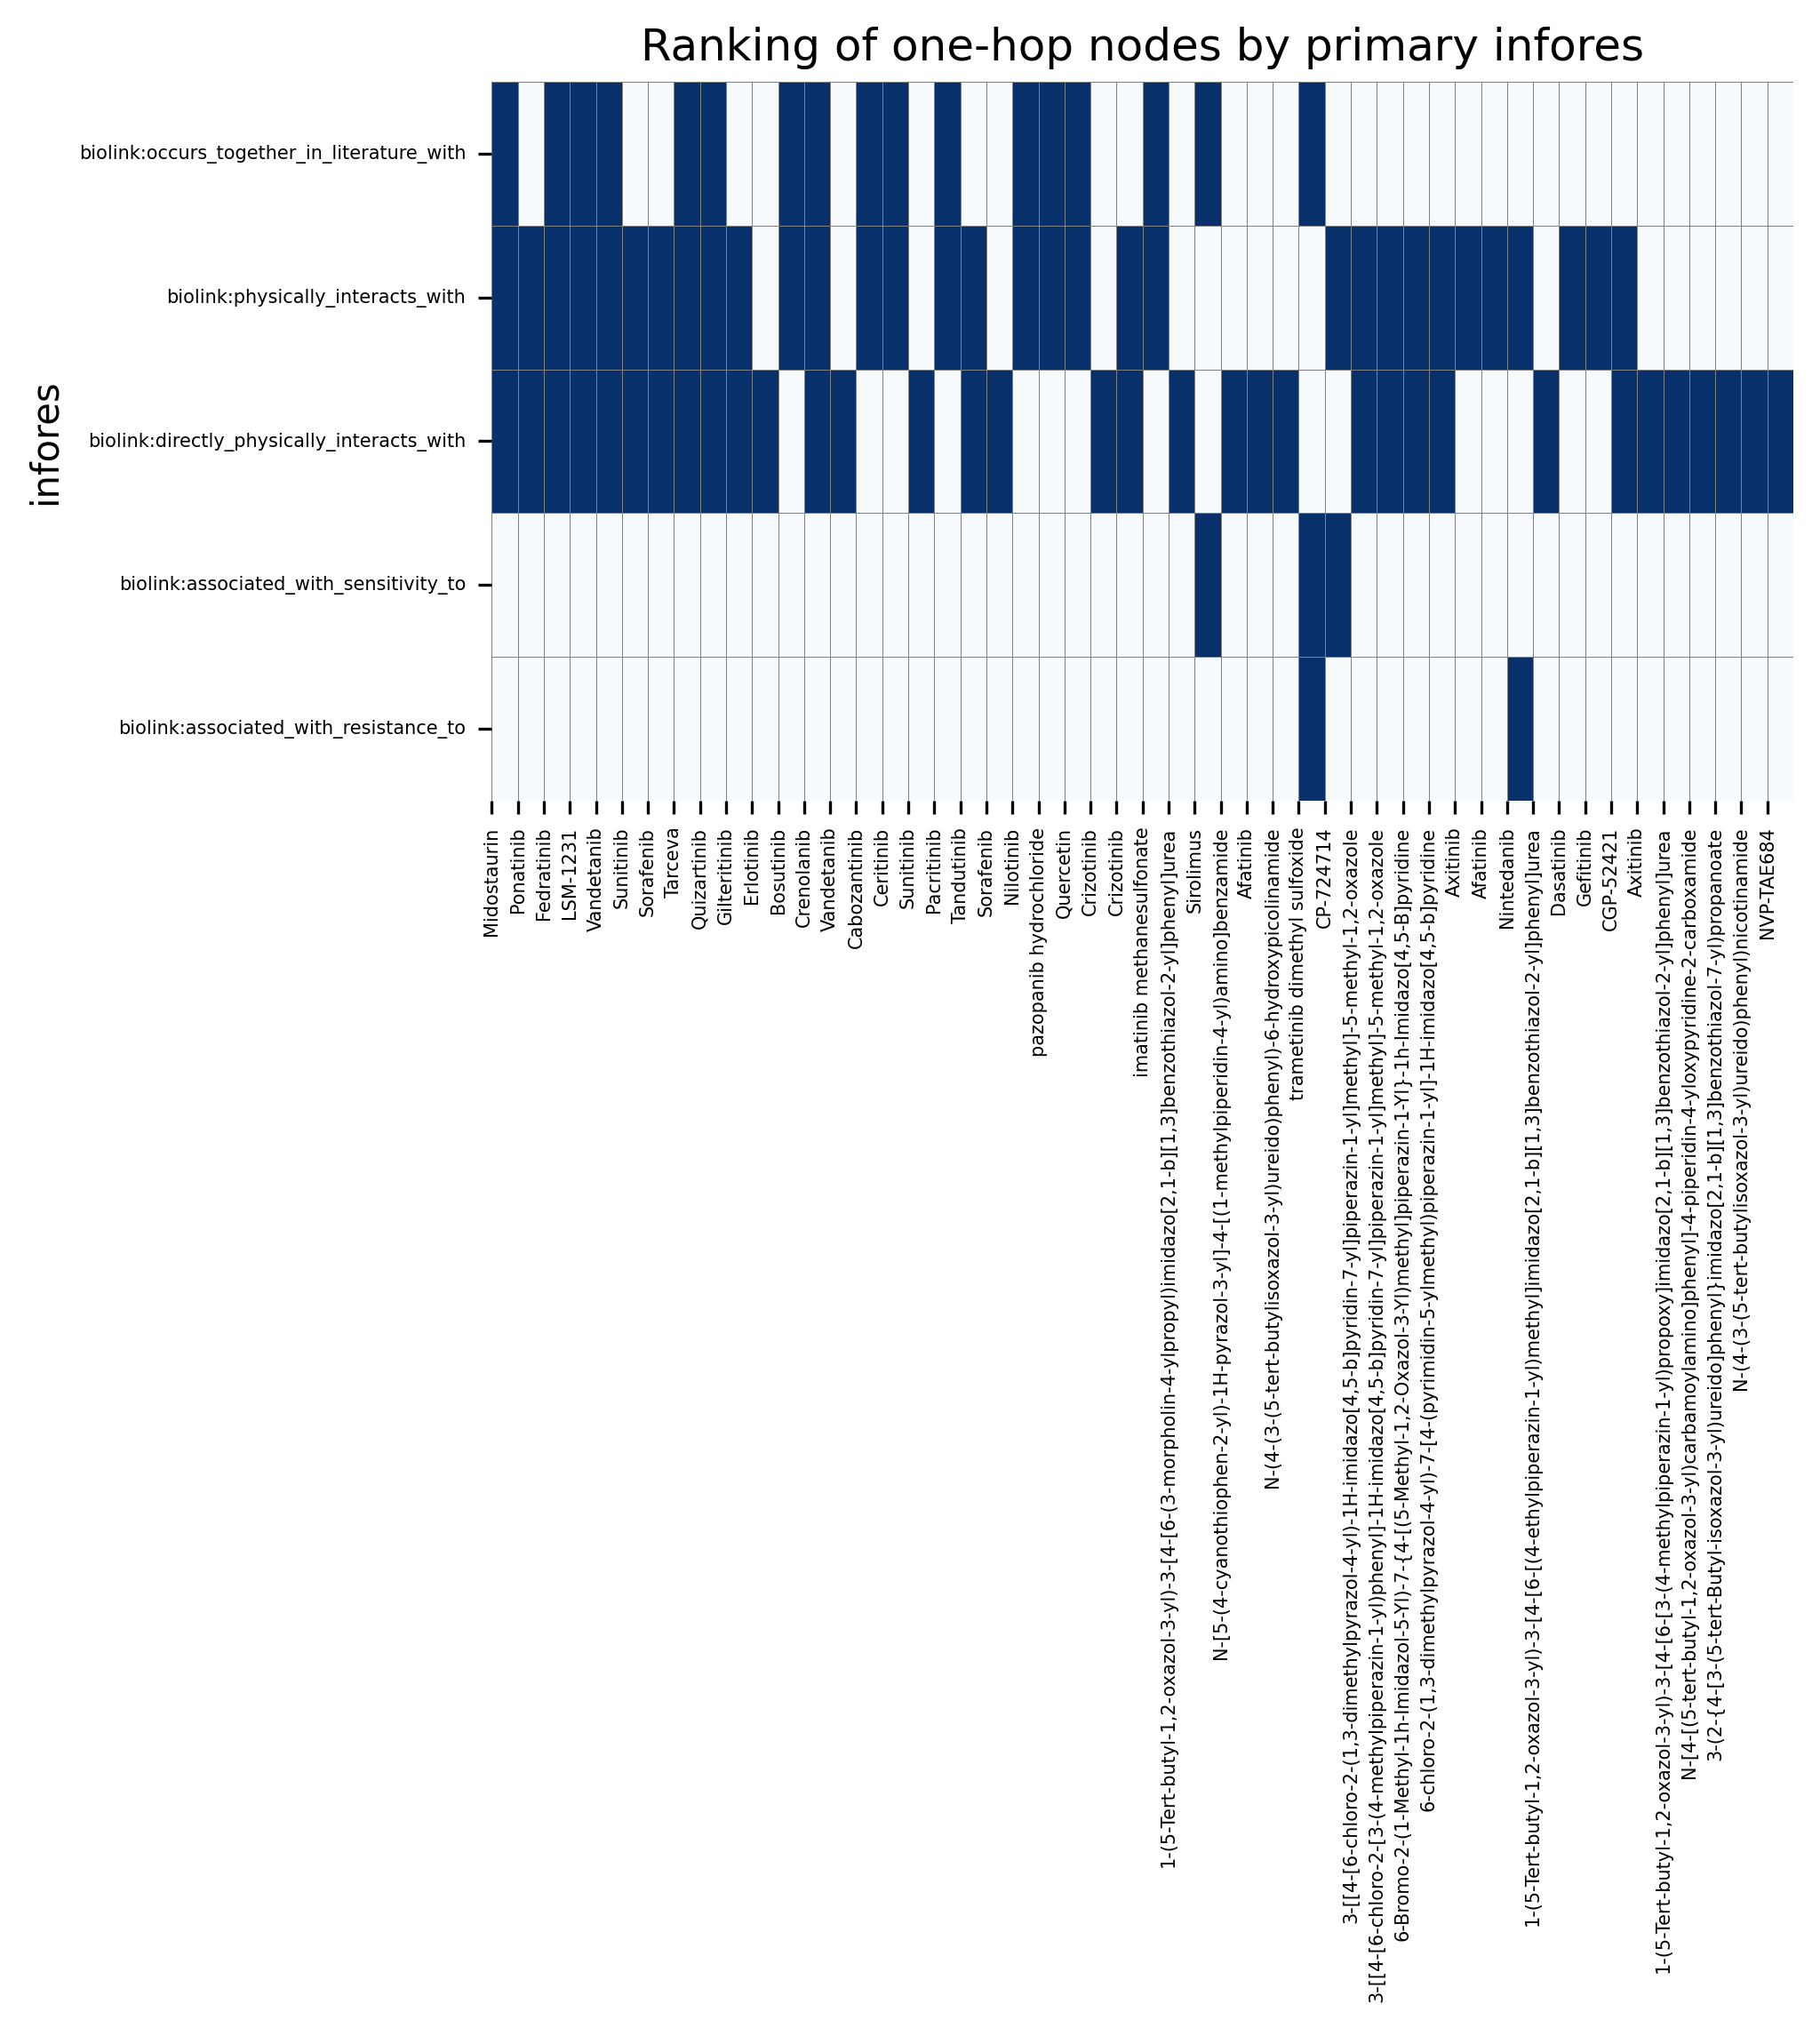

,Midostaurin,Ponatinib,Fedratinib,LSM-1231,Vandetanib,Sunitinib,Sorafenib,Tarceva,Quizartinib,Gilteritinib,...,INCHIKEY:TVOBCJAKLFDOFL-WEBLMRDCSA-N,INCHIKEY:VXGYSGCTPBOVEG-CXIWYSOXSA-N,INCHIKEY:KQTRQDMQBAIPKT-HDJSIYSDSA-N,INCHIKEY:RXNGZWXHXININL-IBFNMHAXSA-N,INCHIKEY:GMAFXYZWTSGYMU-LCKWQUASSA-N,4-[[2-(butylamino)-5-[5-[[(3R)-3-(dimethylamino)pyrrolidin-1-yl]methyl]pyridin-2-yl]pyrimidin-4-yl]amino]cyclohexan-1-ol,INCHIKEY:QQTWEWAFAIDGJB-MXVIHJGJSA-N,2-[[2-(Butylamino)-5-pyridin-2-ylpyrimidin-4-yl]amino]ethanol,INCHIKEY:WORRXRIVSMTSEB-CXIWYSOXSA-N,FLT3-IN-5e
biolink:occurs_together_in_literature_with,1,0,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
biolink:physically_interacts_with,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
biolink:directly_physically_interacts_with,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
biolink:associated_with_sensitivity_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:associated_with_resistance_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 50, input_query = input_node1_id, 
                                fontsize = 5)


In [13]:
# End of the example
